In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
import utils
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
AB_scale = 128
width = 256
height = 256

In [4]:
img_transform = transforms.Compose([transforms.ToTensor()]) 
dataset = utils.LabDataSet('data/mariposas_256',
                img_transform, train_size= 800, test_size=32, height=height, width=width)

In [5]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=dataset.train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset.test_set, batch_size=batch_size, shuffle=False)

In [6]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1, bias=True)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1, bias=True)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1, padding=1, bias=True)
    self.conv_latent = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=1, padding=1, bias=True)

    self.conv1Stride = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2, padding=1, bias=True)
    self.conv2Stride = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=2, padding=1, bias=True)
    self.conv3Stride = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=2, padding=1, bias=True)
    self.conv4Stride = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=2, padding=1, bias=True)


  def forward(self, image):
    layer_1 = F.relu(self.conv1(image))
    compress_1 = F.relu(self.conv1Stride(layer_1))
    layer_2 = F.relu(self.conv2(compress_1))
    compress_2 = F.relu(self.conv2Stride(layer_2))
    layer_3 = F.relu(self.conv3(compress_2))
    compress_3 = F.relu(self.conv3Stride(layer_3))
    layer_4 = F.relu(self.conv4(compress_3))
    compress_4 = F.relu(self.conv4Stride(layer_4))
    latent = F.relu(self.conv_latent(compress_4))
    return latent

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.conv_latent = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3), stride=1, padding=1, bias=True)
    self.conv1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=1, padding=1, bias=True)
    self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=1, padding=1, bias=True)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=(3,3), stride=1, padding=1, bias=True)

  def forward(self, latent):
    from_latent = F.relu(self.conv_latent(latent))
    latent_extended = F.upsample(from_latent, scale_factor=2, mode='nearest')
    layer_1 = F.relu(self.conv1(latent_extended))
    layer_1_extended = F.upsample(layer_1, scale_factor=2, mode='nearest')
    layer_2 = F.relu(self.conv2(layer_1_extended))
    layer_2_extended = F.upsample(layer_2, scale_factor=2, mode='nearest')
    layer_3 = F.relu(self.conv3(layer_2_extended))
    layer_3_extended = F.upsample(layer_3, scale_factor=2, mode='nearest')     
    layer_4 = F.relu(self.conv4(layer_3_extended))
    return F.tanh(layer_4)


In [7]:
class Autoencoder(nn.Module):
   def __init__(self):
      super(Autoencoder, self).__init__()
      self.encoder = Encoder()
      self.decoder = Decoder()
      
      self.relu = nn.ReLU()

      self.final = nn.Tanh()
      
      self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
      
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=2, padding=1, bias=True)
      self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=2, padding=1, bias=True)
      self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=2, padding=1, bias=True)
      self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=1, padding=1, bias=True)

      self.conv8 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv9 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv10 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv11 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv12 = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=(3,3), stride=1, padding=1, bias=True)


      self.color = nn.Sequential(
          self.conv1,
          self.relu,
          self.conv2,
          self.relu,
          
          self.conv3,
          self.relu,
          self.conv4,
          self.relu,

          self.conv5,
          self.relu,
          self.conv6,
          self.relu,

          self.conv7,
          self.relu,

          self.conv8,
          self.relu,

          self.conv9,
          self.relu,
          self.upsampling,

          self.conv10,
          self.relu,
          self.upsampling,
          
          self.conv11,
          self.relu,
          self.conv12,
          self.upsampling,
          self.final
      )

   def forward(self, x):
      latent = self.encoder(x)
      color_prediction = self.decoder(latent)
      return  color_prediction

In [8]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = [] 
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0
    
      for image_batch, image_batch_r, name_image in train_loader:
          image_batch_r = image_batch_r.to(device)
          
          image_batch = torch.unsqueeze(image_batch, dim=1)
          image_batch = image_batch.to(device)

          image_batch_recon = model(image_batch)
          loss = loss_fn(image_batch_recon, image_batch_r)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
          
      train_loss_avg[-1] /= num_batches
      if epoch%1==0:
        print('Epoch [%d / %d] average error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
      if epoch%20==0 and epoch!=0:
        utils.plot_batch(device, test_loader, model, height=256, width=256,step =16)
        model.train()
    return train_loss_avg

In [9]:
learning_rate = 1e-3
autoencoder = Autoencoder()
autoencoder.to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate)

autoencoder.train()
loss_result = train(autoencoder,train_loader,200,loss)

Epoch [1 / 200] average error: 0.022317
Epoch [2 / 200] average error: 0.019980


/home/fabrizio/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 27 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/home/fabrizio/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 49 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/home/fabrizio/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 97 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/home/fabrizio/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 43 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/home/fabrizio/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 522 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/home/fabrizio/anac

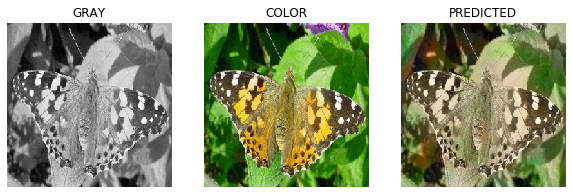

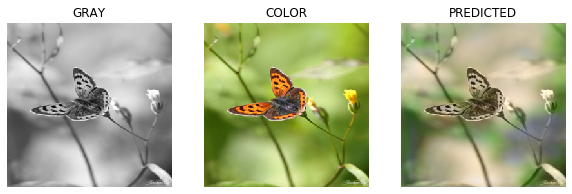

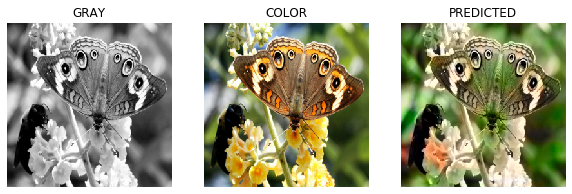

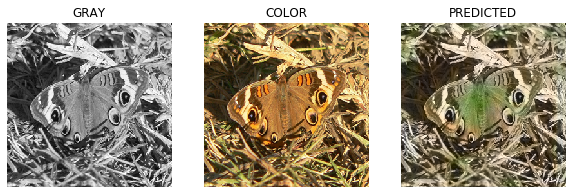

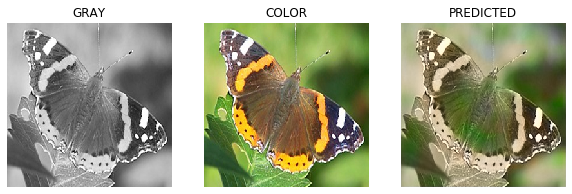

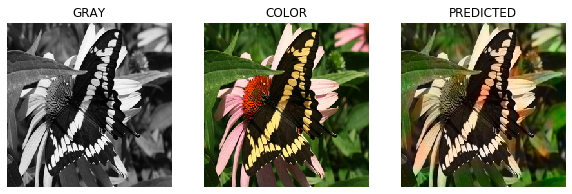

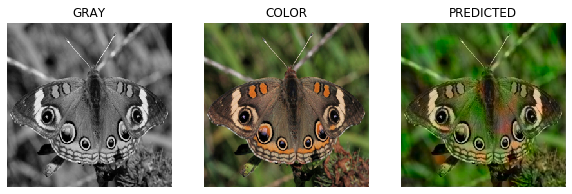

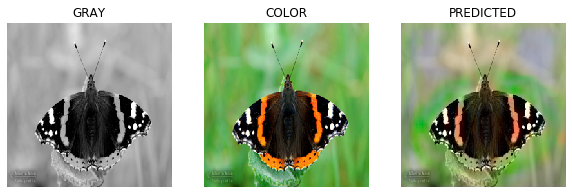

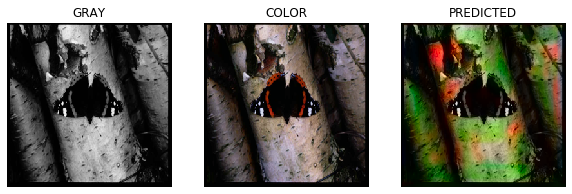

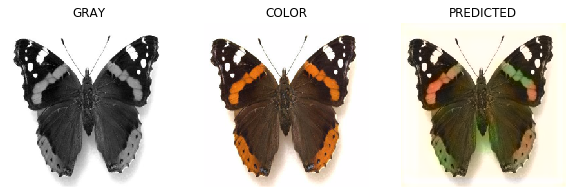

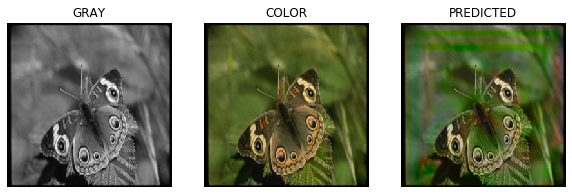

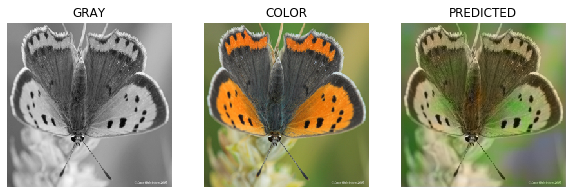

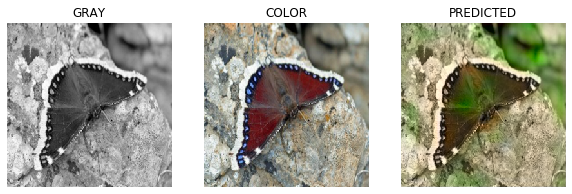

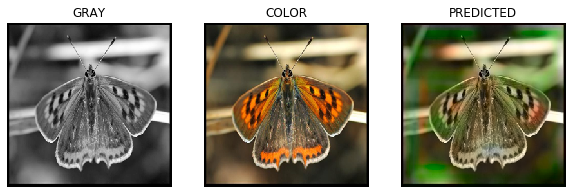

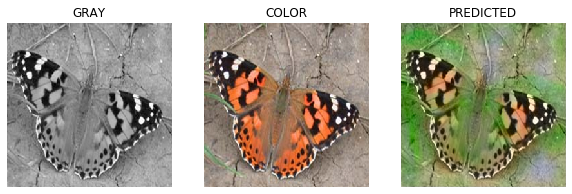

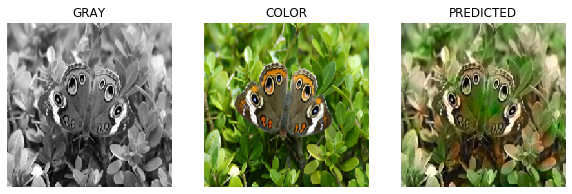

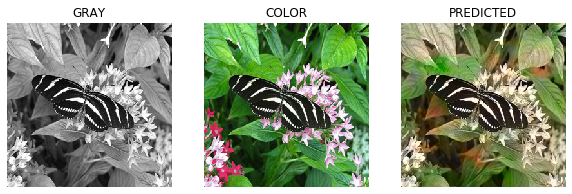

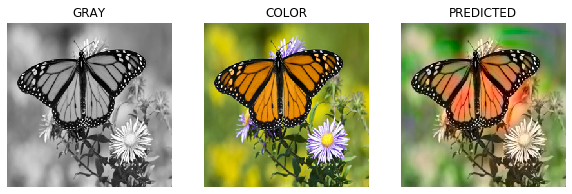

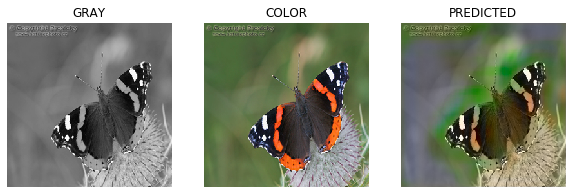

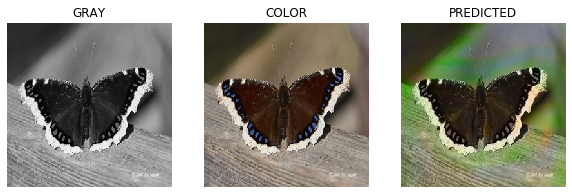

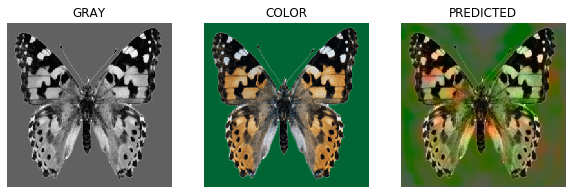

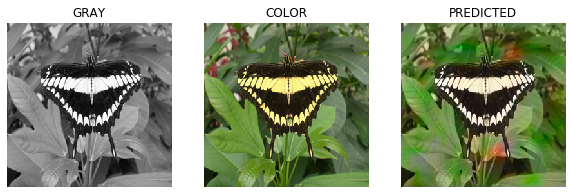

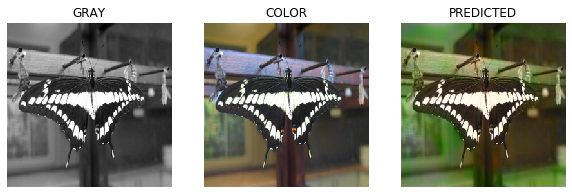

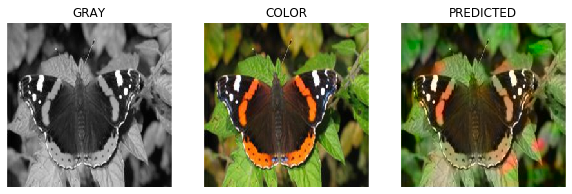

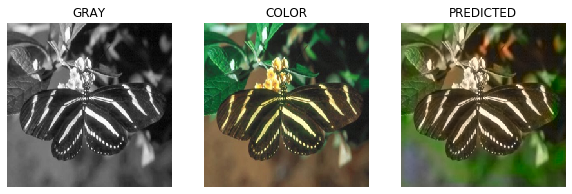

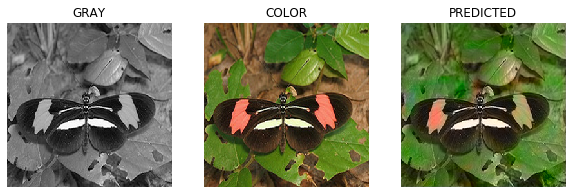

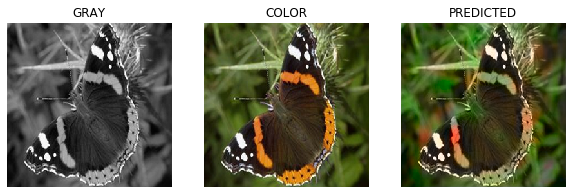

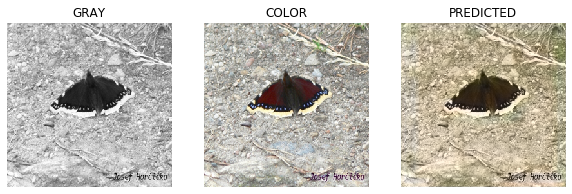

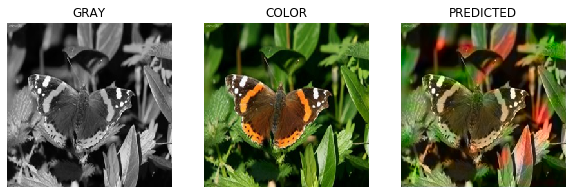

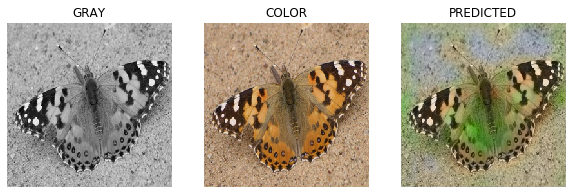

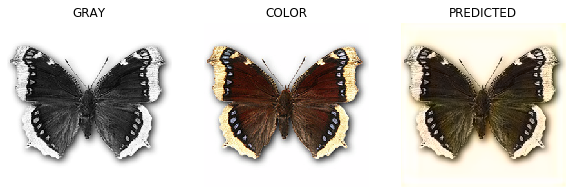

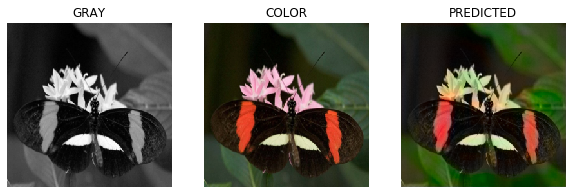

In [ ]:
utils.plot_batch(device, test_loader, autoencoder, height=256, width=256, step =1)